# Prédiction d'AVC (Strokes)

## Contexte

Ce Notebook a pour objectif la mise en place d'un modèle de Machine Learning permettant de prédire si une personne va subir une attaque en se basant sur les données suivantes : 

- **Sexe**
- **Age**
- **Hypertension** 
- **Heart Disease**
- **Statut Marital**
- **Type de Poste de Travail**
- **Type de Résidence**
- **Niveau Moyen de Glucose**
- **Indice de Masse Corporelle**
- **Fumeur/Non fumeur**

## Jeu de données

Le jeu de donnée est un fichier `csv`, fournit par DataScientest et est disponible sous AWS S3 [Ici](https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/strokes.csv)

In [1]:
# Import des Librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, \
make_scorer, fbeta_score

from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, \
train_test_split, cross_val_predict

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import itertools
import pickle

LABELS = ["Non AVC/Attaque" , 'AVC/Attaque']

COLUMNS = ['KFold', 'methode', 'model', 'test_accuracy', 'test_f1', 'test_fbeta', 'test_precision', 'test_recall']
KFOLD=5

In [2]:
DATASET_PATH = 'https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/strokes.csv'
df = pd.read_csv(DATASET_PATH, index_col='id')
df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# taille du dataset
df.shape

(5110, 11)

In [4]:
# type colonnes dataset
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

## Analyse Exploratoire 

On constate que notre jeu de données est composé de données qualitatives et quantitatives.


1.   ***Données Qualitatives***
- Gender / Sexe
- Ever Married / Statut Marital
- Work Type / Type de Poste de Travail
- Residence Type / Type de Résidence
- Smoking Status / Fumeur

2.   ***Données Quantitatives***

- Age 
- BMI / Indice de Masse Corporelle

3.   ***Données Binaires***

- Hypertension : Variable binaire, `1` la personne est en hypertentsion,`0` non.
- Heart Disease / Maladie Cardique : Variable binaire, `1` la personne est a une maladie cardiaque,`0` non.

La variable expliquée / Target est la colonne **Stroke** de type binaire, elle peut prendre deux valeurs [0, 1]. On est face à une problématique de classification binaire. 

1. La présence de variables qualitatives / catégorielle, nécessitera une étape de transformation en valeurs numérique avant d'entrainer nos modèles.

2. Les variables binaires sont par défaut de type numériques, mais leur type sera converti en Object. 

In [5]:
# convetir en Object les deux colonnes Hypertension et Heart Disease 
df[['hypertension','heart_disease']]=df[['hypertension','heart_disease']].astype('O')

In [6]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.dtypes

gender                object
age                  float64
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
# Dissociation des variables catégorielles et numériques :

In [9]:
var_num=['age','avg_glucose_level','bmi']
var_cat=['gender','hypertension','heart_disease','work_type','Residence_type','smoking_status','ever_married']

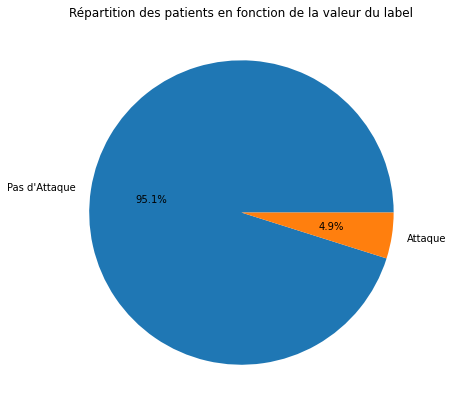

In [10]:
plt.figure(figsize=(7, 7))
plt.pie(df['stroke'].value_counts(), labels=["Pas d'Attaque","Attaque"], autopct='%.1f%%')
plt.title('Répartition des patients en fonction de la valeur du label')
plt.show()

On remarque un important déséquilibre des classes. 

## Visualisation / Graphiques

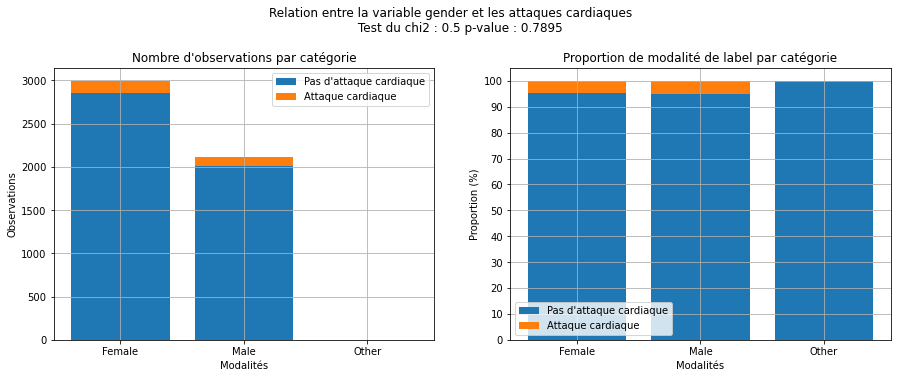

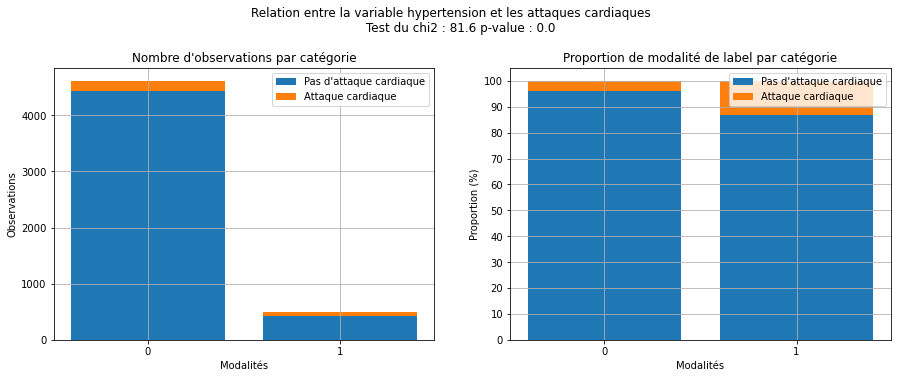

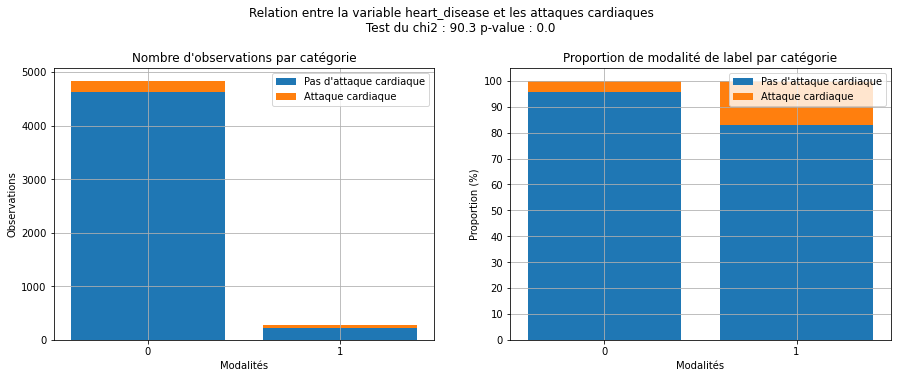

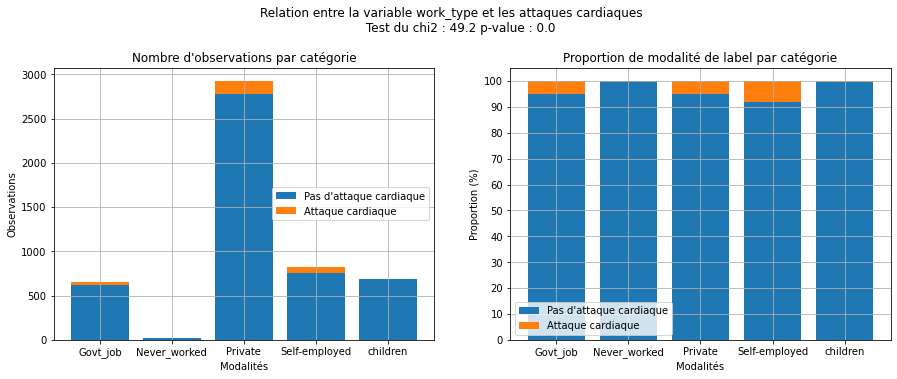

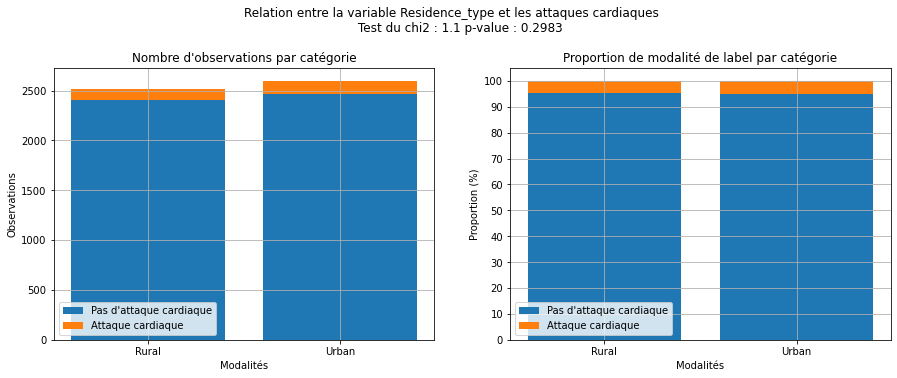

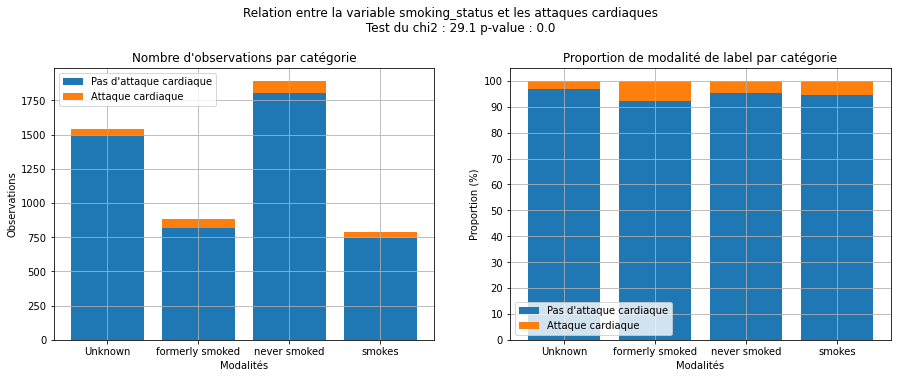

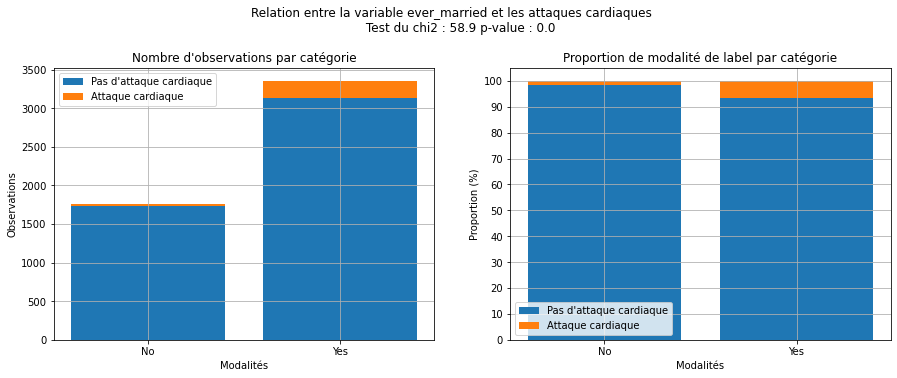

In [12]:
for var in var_cat :
    
    cr_tb_1=pd.crosstab(df['stroke'],df[var])
    cr_tb_2=pd.crosstab(df['stroke'],df[var], normalize=1)

    x=len(cr_tb_1.columns)
    y1=cr_tb_1.loc[0]
    y2=cr_tb_1.loc[1]
    y3=cr_tb_2.loc[0]
    y4=cr_tb_2.loc[1]
    
    chi2=chi2_contingency(cr_tb_1)
    xlab=cr_tb_1.columns
    fig=plt.figure(figsize=(15,5))
    
    ax1=fig.add_subplot(121)
    ax1.bar(range(0,x),y1, label='Pas d\'attaque cardiaque')
    ax1.bar(range(0,x),y2, bottom=y1,label='Attaque cardiaque')
    ax1.set_xticks(range(0,x))
    ax1.set_xticklabels(xlab)
    ax1.set_ylabel('Observations')
    ax1.set_xlabel('Modalités')
    ax1.legend()
    ax1.set_title('Nombre d\'observations par catégorie')
    plt.grid(True)
    
    ax2=fig.add_subplot(122)
    ax2.bar(range(0,x),y3,label='Pas d\'attaque cardiaque')
    ax2.bar(range(0,x),y4,label='Attaque cardiaque', bottom=y3)
    ax2.set_xticks(range(0,x))
    ax2.set_xticklabels(xlab)
    ax2.set_yticks(np.arange(0,1.1,0.1))#,np.arange(0,110,10))
    ax2.set_yticklabels(np.arange(0,110,10))
    ax2.set_ylabel('Proportion (%)')
    ax2.legend()
    ax2.set_ylim((0,1.05))
    ax2.set_xlabel('Modalités')
    ax2.set_title('Proportion de modalité de label par catégorie')
    
    fig.suptitle('Relation entre la variable {} et les attaques cardiaques\
    \n Test du chi2 : {} p-value : {}'.format(var,round(chi2[0],1),round(chi2[1],4)), y=1.05)
    plt.grid(True)
    plt.show();

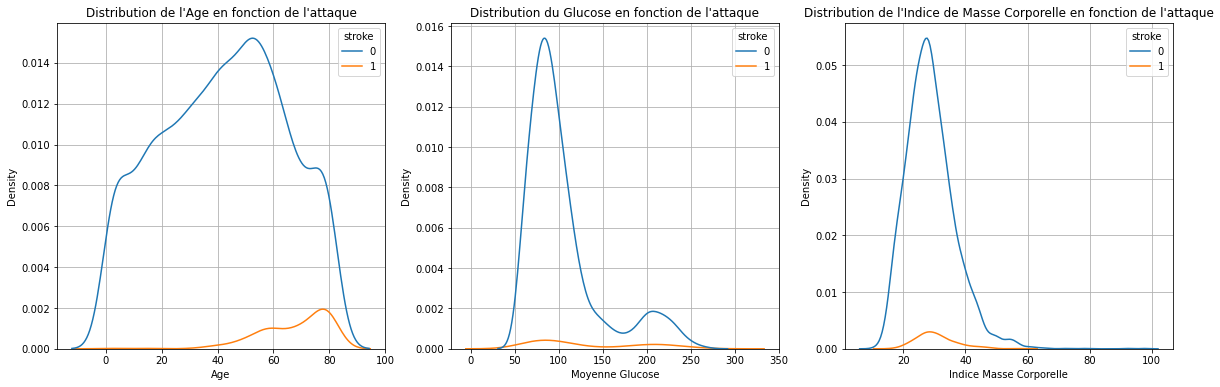

In [13]:
plots_definition = {
    'age': {'index':1, 'title': "Distribution de l'Age en fonction de l'attaque", 'xlabel':'Age'},    
    'avg_glucose_level': {'index': 2, 'title': "Distribution du Glucose en fonction de l'attaque", 'xlabel':'Moyenne Glucose'},
    'bmi': {'index': 3, 'title': "Distribution de l'Indice de Masse Corporelle en fonction de l'attaque", 'xlabel':'Indice Masse Corporelle'}
}

plt.figure(figsize = (20, 6))
for key in plots_definition.keys():
    plot_def = plots_definition[key]
    plt.subplot(1, 3, plot_def['index'])
    title = plot_def['title']
    xlabel = plot_def['xlabel']
    
    sns.kdeplot(x=key, hue="stroke", data=df)    
    plt.title(title)    
    plt.xlabel(xlabel) 
    plt.grid(True)
plt.show()

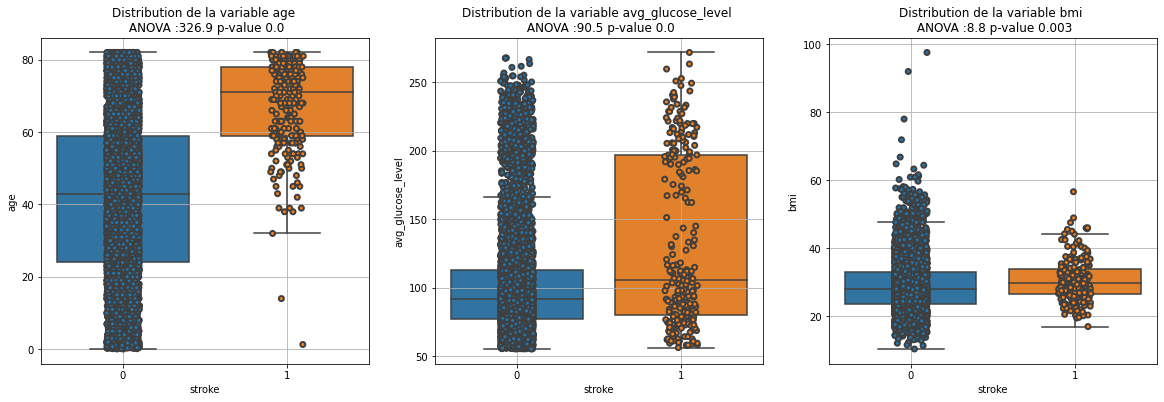

In [14]:
fig,axs=plt.subplots(1,3,figsize=(20,6))

for ind,var in enumerate(var_num):
    df_ano=df[['stroke',var]].dropna()
    anov=f_classif(df_ano[var].values.reshape(-1,1),df_ano['stroke'])
    sns.boxplot(x=df_ano['stroke'],y=df_ano[var], ax=axs[ind], fliersize=0)
    sns.stripplot(x=df_ano['stroke'],y=df_ano[var], ax=axs[ind], linewidth=2)

    axs[ind].set_title('Distribution de la variable {} \n ANOVA :{} p-value {}'.\
              format(var,round(anov[0][0],1),round(anov[1][0],4)))
    axs[ind].grid(True)

## Analyse Statistique 

### Valeurs Manquantes

In [15]:
df.loc[df['bmi'].isnull(),'stroke'].value_counts(normalize=True)

0    0.800995
1    0.199005
Name: stroke, dtype: float64

In [16]:
df.loc[df['bmi'].notnull(),'stroke'].value_counts(normalize=True)

0    0.957425
1    0.042575
Name: stroke, dtype: float64

In [17]:
df.isna().any(axis=1).sum()

201

On a **201** lignes avec au moins une valeur manquantes. La variable BMI est celle qui contient ces valeurs manquantes. Avant de pouvoir faire notre analyse statistique on se doit de traiter les NaN.

- Plusieurs méthodes sont possible: Utilisation du Mean/Median, Utilisation de la similarité (comme par exemple KMeans). Ici on se propose d'utiliser la Median.

- Il y a une proportion beaucoup plus importante d'attaques au sein des observations dont le bmi est NaN que lorsqu'une valeur est renseignée. Une variable binaire sera créée pour séparer ces deux catégories et la moyenne sera utilisée pour renseigner les valeurs manquantes.

In [18]:
df['bmi_nan']=np.nan
df.loc[df['bmi'].isnull(),'bmi_nan']='oui'
df.loc[df['bmi'].notnull(),'bmi_nan']='non'
df['bmi']=df['bmi'].fillna(df['bmi'].mean())
var_cat.append('bmi_nan')

## Modélisation


In [24]:
# Séparer en variable explicatives et variable expliquée (Target)
X=df.drop(columns=['stroke'])
y=df['stroke']

In [27]:
def show_metrique(model, X_test, y_test):
  """
    Afficher métriques : classification report, matrice de confusion pour (X_test, y_test) 
  """
  # Predictions
  y_pred=cross_val_predict(model, X_test, y_test, cv=StratifiedKFold(n_splits=KFOLD))
  
  # Confusion Matrix
  cm=confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6, 6))
  plt.imshow(cm, interpolation='nearest')
  plt.title("Matrice de confusion")
  plt.colorbar() 
  
  tick_marks = np.arange(len(LABELS))
  plt.xticks(tick_marks, LABELS)
  plt.yticks(tick_marks, LABELS)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="black", fontsize='x-large')
  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits') 
  plt.show() 

  # Classification Report 
  print(classification_report(y_test, y_pred, target_names=LABELS))

In [28]:
def run_and_evaluate(model, params, X_data, y_data):
  """
  Permet de faire tourner un pipeline ML pour le model en entrée sur X, y
  """
  variables_numeriques=X_data.select_dtypes('number').columns
  variables_categorielles=X_data.select_dtypes(exclude = 'number').columns

  # Columns transformation
  transformer=make_column_transformer((StandardScaler(), variables_numeriques) \
      ,(OneHotEncoder(handle_unknown='ignore'), variables_categorielles))\

  # Cross Validation via KFold
  kf=StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=0)

  # Metrique d'Evaluation
  f1b=make_scorer(fbeta_score, beta=2)

  # Partie commune
  model.scoring = f1b
  model.cv=kf

  # Récupérer Pre steps si nécessaire
  steps = []
  if 'steps' in params:
    steps.append(params['steps'])

  # Steps communes  
  steps.append(('transformer', transformer))
  steps.append(('classifier', model))
  pipeline = Pipeline(steps)

  # Cross Validation
  scoring = {"accuracy": "accuracy", 'recall':'recall',  'precision':'precision','f1':'f1','fbeta':f1b}
  cross_val = cross_validate(pipeline, X_data, y_data, cv=kf, scoring=scoring, return_estimator=True)

  # Df donnant les métriques par méthode. 
  data = {'KFold': range(1, 6), 'methode': [params['methode']]*KFOLD, 'model': [params['model']]*KFOLD}
  for column in COLUMNS[3:]:
    data[column] = cross_val[column]

  df_result=pd.DataFrame(data=data, columns=COLUMNS)
  
  # Predictions
  y_pred=cross_val_predict(pipeline, X_data, y_data, cv=StratifiedKFold(n_splits=KFOLD))
  
  return df_result, pipeline, y_pred, cross_val

In [29]:
df_metrics = pd.DataFrame()
prediction_dictionary = {}

### Comparaison des différentes méthodes de retraitement du déséquilibre des classes de label

#### a) aucun retraitement

In [30]:
lrc = LogisticRegressionCV()
params = {'methode': 'Rien', 'model': 'Logistic Regression'}
df_result, pipeline, y_pred, cross_val = run_and_evaluate(lrc, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['Rien'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,Rien,Logistic Regression,0.949119,0.000000,0.000000,0.000000,0.000000
1,2,Rien,Logistic Regression,0.950098,0.000000,0.000000,0.000000,0.000000
2,3,Rien,Logistic Regression,0.951076,0.038462,0.024752,0.500000,0.020000
3,4,Rien,Logistic Regression,0.950098,0.072727,0.048780,0.400000,0.040000
4,5,Rien,Logistic Regression,0.951076,0.038462,0.025126,0.333333,0.020408


#### b) Oversampling / SMOTE

In [31]:
sm=SMOTENC(X.dtypes=='object', random_state=0)

In [32]:
lrc = LogisticRegressionCV()
params = {'methode': 'SMOTE', 'model': 'Logistic Regression', 'steps': ('smote', sm)}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(lrc, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['SMOTE'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,SMOTE,Logistic Regression,0.753425,0.142857,0.236486,0.086066,0.420000
1,2,SMOTE,Logistic Regression,0.738748,0.188450,0.323591,0.111111,0.620000
2,3,SMOTE,Logistic Regression,0.757339,0.225000,0.382979,0.133333,0.720000
3,4,SMOTE,Logistic Regression,0.742661,0.210210,0.362319,0.123675,0.700000
4,5,SMOTE,Logistic Regression,0.741683,0.200000,0.345912,0.117438,0.673469


#### c) Undersampling

In [33]:
ru=RandomUnderSampler(random_state=0)

In [34]:
lrc = LogisticRegressionCV()
params = {'methode': 'UNDER', 'model': 'Logistic Regression', 'steps': ('ru', ru)}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(lrc, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['UNDER'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,UNDER,Logistic Regression,0.757339,0.234568,0.400844,0.138686,0.760000
1,2,UNDER,Logistic Regression,0.698630,0.222222,0.402930,0.127168,0.880000
2,3,UNDER,Logistic Regression,0.696673,0.213198,0.386029,0.122093,0.840000
3,4,UNDER,Logistic Regression,0.724070,0.225275,0.398833,0.130573,0.820000
4,5,UNDER,Logistic Regression,0.705479,0.205805,0.370722,0.118182,0.795918


#### d) modification des poids des classes dans les fonctions de coût

In [35]:
lrc = LogisticRegressionCV(class_weight='balanced')
params = {'methode': 'Class Weight', 'model': 'Logistic Regression'}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(lrc, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['Class Weight'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,Class Weight,Logistic Regression,0.779843,0.226804,0.374150,0.136929,0.66000
1,2,Class Weight,Logistic Regression,0.734834,0.236620,0.415842,0.137705,0.84000
2,3,Class Weight,Logistic Regression,0.749511,0.238095,0.411523,0.139860,0.80000
3,4,Class Weight,Logistic Regression,0.739726,0.231214,0.403226,0.135135,0.80000
4,5,Class Weight,Logistic Regression,0.754403,0.232416,0.400844,0.136691,0.77551


In [36]:
# Taille du df de metriques
df_metrics.shape

(20, 8)

#### Evaluation / Métriques


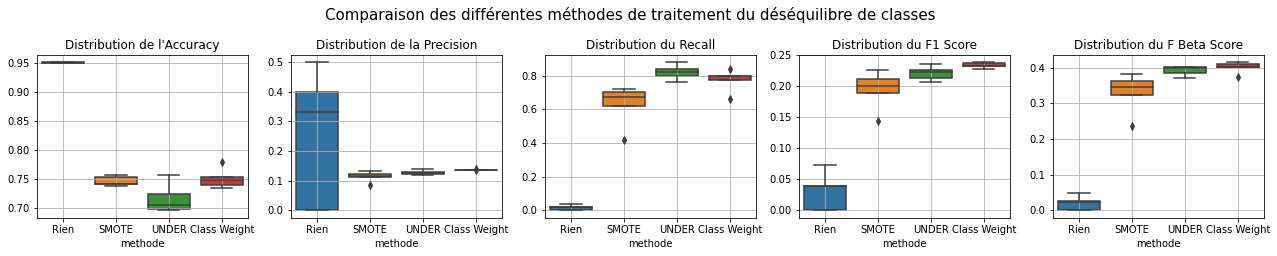

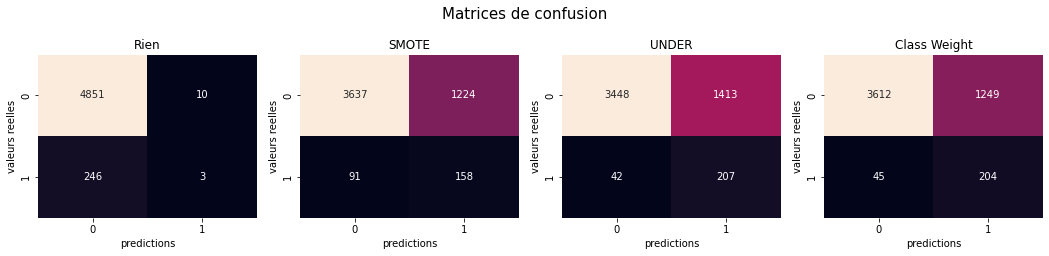

In [37]:
df_to_plot = df_metrics[df_metrics['model'] == 'Logistic Regression']
boxplot_conf = {
    'test_accuracy': {'title' : 'Distribution de l\'Accuracy'},
    'test_precision': {'title' : 'Distribution de la Precision'},
    'test_recall': {'title' : 'Distribution du Recall'},
    'test_f1': {'title' : 'Distribution du F1 Score'},
    'test_fbeta': {'title' : 'Distribution du F Beta Score'}
}

# Box plot
fig, axs =plt.subplots(1, 5, figsize=[22, 3])
fig.suptitle('Comparaison des différentes méthodes de traitement du déséquilibre de classes', fontsize=15, y=1.1)
for index, key in enumerate(boxplot_conf.keys()):
  sns.boxplot(data=df_to_plot, x='methode', y=key, ax=axs[index])
  axs[index].set_title(boxplot_conf[key]['title'])
  axs[index].grid(True)
  axs[index].set_ylabel('')
plt.show()

# Matrice de Confusion
fig, axs=plt.subplots(1,4, figsize=(18,3))
fig.suptitle('Matrices de confusion', fontsize=15,y=1.1)
for index, key in enumerate(prediction_dictionary.keys()):
  predictions=prediction_dictionary[key]
  matconf=pd.crosstab(y.values, predictions)
  matconf.columns.name='predictions'
  matconf.index.name='valeurs reelles'
  sns.heatmap(matconf,annot=True,fmt='d', cbar=False, ax=axs[index])
  axs[index].set_title(key)
plt.show()

plt.show()

## Analyses / Observations

Des différentes téchniques utilisées pour pallier au problème du dééquilibre du dataset, on remarque qu'on obtient obtient une très bonne **accuracy**. Pour ce qui du cas de base (Dataframe original) on a même une excellente **accuracy**. Cependant celui ci est uniquement du à la capacité du à prédire correctement la classe 0, qui représente 95% du dataset alors que la quasi totalité de la classe 1 (les attaques) est incorrectement prédite.

Dans ce type de situation nous pouvons partir de l'hypothèse que les erreurs de **type II** (non détection d'attaques cardiaques) sont bien plus graves que les erreurs de **type I** (fausses alertes).
L'accuracy n'est donc pas la métrique la plus pertinente pour évaluer le meilleur modèle. 

Le **F1 score**, moyenne harmonique du recall et de la precision, est une métrique bien plus adaptée à la situation. 

Le **F1 beta score** (avec beta=2) est un f1-score qui accorde plus d'importance au recall (pourcentage d'attaques correctement prédites) qu'à la precision (pourcentage de valeurs correctement prédites parmi les prédiction d'attaques), cette métrique semble encore plus adaptée à notre problématique. 

Selon cette dernière, **la méthode qui consiste à moduler les poids des labels dans la fonction de coût des modèles, via l'option class_weight='balanced' présente le meilleur résultat**, suivi de l'undersampling et de l'oversampling avec SMOTE. Ne rien faire conduit à une performance très faible

## Conclusion

En comparant les deux métriques : **F1 Score** et **F1 Beta = 2**, on constate que la téchique qui donne les meilleurs perfomances est celle avec **Class Weight = Balanced**


On propose d'utiliser cette téchnique par la suite, sur différents modèles.

In [38]:
df_metrics = pd.DataFrame()
prediction_dictionary = {}

## Logistic Regression CV

Dans cette partie, on propose de passer par une étape de tunning de l'hyper paramètre **`C`** [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) du modèle Logistic Regression.

In [39]:
lr_cv = LogisticRegressionCV(class_weight='balanced')
params = {'methode': 'Class Weight', 'model': 'Logistic Regression'}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(lr_cv, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['Class Weight'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,Class Weight,Logistic Regression,0.779843,0.226804,0.374150,0.136929,0.66000
1,2,Class Weight,Logistic Regression,0.734834,0.236620,0.415842,0.137705,0.84000
2,3,Class Weight,Logistic Regression,0.749511,0.238095,0.411523,0.139860,0.80000
3,4,Class Weight,Logistic Regression,0.739726,0.231214,0.403226,0.135135,0.80000
4,5,Class Weight,Logistic Regression,0.754403,0.232416,0.400844,0.136691,0.77551


In [40]:
df_metrics.shape

(5, 8)

In [41]:
# Construire un Dataframe donnant le F Beta score pour les différentes valeur de l'hyper parametre C
cv_lr=pd.DataFrame()
for i in range(5):
    cv_lr=cv_lr.append(pd.DataFrame(cross_val['estimator'][i][1].scores_[1]))
cv_lr.columns=cross_val['estimator'][i][1].Cs_
cv_lr_melt=round(cv_lr.melt(var_name='C'), 4)
cv_lr_melt=cv_lr_melt.rename({'value':'F1 beta score'}, axis=1)

In [42]:
cv_lr.shape

(25, 10)

In [43]:
cv_lr.head()

,0.000100,0.000774,0.005995,0.046416,0.359381,2.782559,21.544347,166.810054,1291.549665,10000.000000
0,0.329949,0.350000,0.378788,0.373711,0.375648,0.378590,0.378590,0.378590,0.378590,0.378590
1,0.416667,0.419501,0.424312,0.422535,0.427553,0.430622,0.429594,0.429594,0.429594,0.429594
2,0.377129,0.406699,0.421836,0.410256,0.426357,0.428571,0.430809,0.430809,0.430809,0.430809
3,0.423077,0.416667,0.429293,0.419847,0.425258,0.426357,0.426357,0.426357,0.426357,0.426357
4,0.383632,0.394402,0.407895,0.422343,0.425824,0.424658,0.424658,0.424658,0.424658,0.424658


In [44]:
# Calcule de la moyenne par hyper parametre
df_cval_lr=cv_lr_melt.groupby('C').agg({'F1 beta score':[np.mean,np.std,np.median]})\
.sort_values(('F1 beta score','mean'), ascending=False)

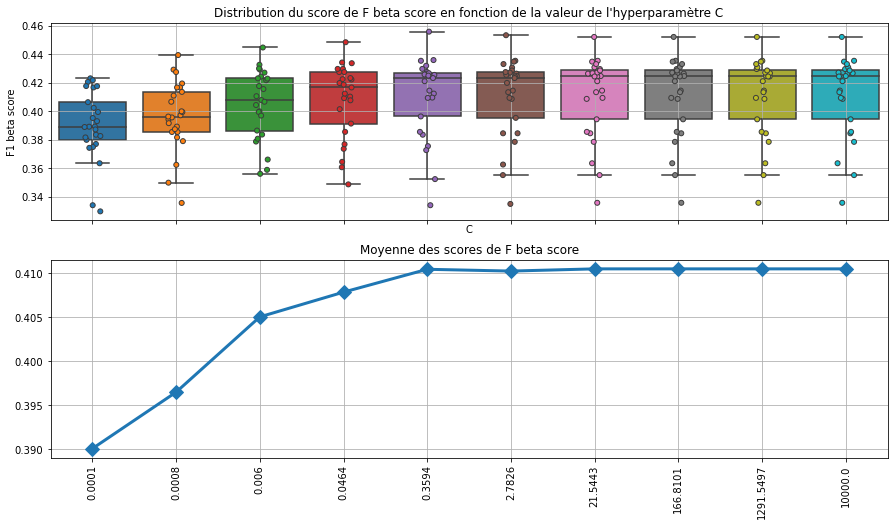

In [45]:
# Box plot de la métrique F1 Beta Score pour chaque hyper parametre C et les 5 KFolds
fig, axs = plt.subplots(2,1,figsize=[15,8], sharex=True)
sns.boxplot(data=cv_lr_melt, x='C', y='F1 beta score', ax=axs[0], fliersize=0)
sns.stripplot(data=cv_lr_melt, x='C', y='F1 beta score', ax=axs[0],linewidth=1)
axs[0].grid()
axs[0].set_title('Distribution du score de F beta score en fonction de la valeur de l\'hyperparamètre C');

# Plot des moyenne sur KFold pour chaqque hyper parametre C
axs[1].plot(df_cval_lr[('F1 beta score','mean')].sort_index().values, marker='D', linewidth=3, markersize=10)
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].grid()
axs[1].set_title('Moyenne des scores de F beta score');

In [46]:
df_cval_lr

F1 beta score                  
                    mean       std  median
C                                         
21.5443         0.410528  0.028472  0.4244
166.8101        0.410528  0.028472  0.4244
1291.5497       0.410528  0.028472  0.4244
10000.0000      0.410528  0.028472  0.4244
0.3594          0.410480  0.028508  0.4233
2.7826          0.410276  0.028582  0.4233
0.0464          0.407876  0.026033  0.4167
0.0060          0.405056  0.024024  0.4079
0.0008          0.396480  0.023955  0.3963
0.0001          0.390048  0.024295  0.3892

La performance est optimale pour C=21.5443

#### Coefficients des Features 

In [47]:
# Récuperation des nom de variables explicatives
var_num_fin=X.select_dtypes('number').columns
var_cat_fin=X.select_dtypes(exclude = 'number').columns

nom_features_cat=cross_val['estimator'][0][0].transformers_[1][1].get_feature_names(var_cat_fin)
nom_features=np.concatenate([var_num_fin,nom_features_cat])
print(nom_features)

['age' 'avg_glucose_level' 'bmi' 'gender_Female' 'gender_Male'
 'gender_Other' 'hypertension_0' 'hypertension_1' 'heart_disease_0'
 'heart_disease_1' 'ever_married_No' 'ever_married_Yes'
 'work_type_Govt_job' 'work_type_Never_worked' 'work_type_Private'
 'work_type_Self-employed' 'work_type_children' 'Residence_type_Rural'
 'Residence_type_Urban' 'smoking_status_Unknown'
 'smoking_status_formerly smoked' 'smoking_status_never smoked'
 'smoking_status_smokes' 'bmi_nan_non' 'bmi_nan_oui']


In [48]:
# Récuperation des coefficient 
df_coefs=pd.DataFrame([cross_val['estimator'][i][1].coef_[0] for i in range(5)], columns=nom_features)

df_coefs_abs=np.abs(df_coefs)
liste_coef=df_coefs.mean().sort_values(ascending=False).index
liste_coef_abs=df_coefs_abs.mean().sort_values(ascending=False).index

In [49]:
df_features=df_coefs[liste_coef].mean()
df_features

age                               1.755827
work_type_children                0.955135
bmi_nan_oui                       0.723313
hypertension_1                    0.160621
avg_glucose_level                 0.156351
bmi                               0.115502
gender_Female                     0.102928
heart_disease_1                   0.095050
smoking_status_smokes             0.071657
Residence_type_Urban              0.008877
smoking_status_formerly smoked   -0.004321
ever_married_No                  -0.015603
work_type_Self-employed          -0.026883
Residence_type_Rural             -0.029874
gender_Male                      -0.035753
ever_married_Yes                 -0.053599
heart_disease_0                  -0.078089
smoking_status_Unknown           -0.110115
smoking_status_never smoked      -0.126429
work_type_Private                -0.148181
gender_Other                     -0.152660
hypertension_0                   -0.156298
work_type_Govt_job               -0.181819
bmi_nan_non

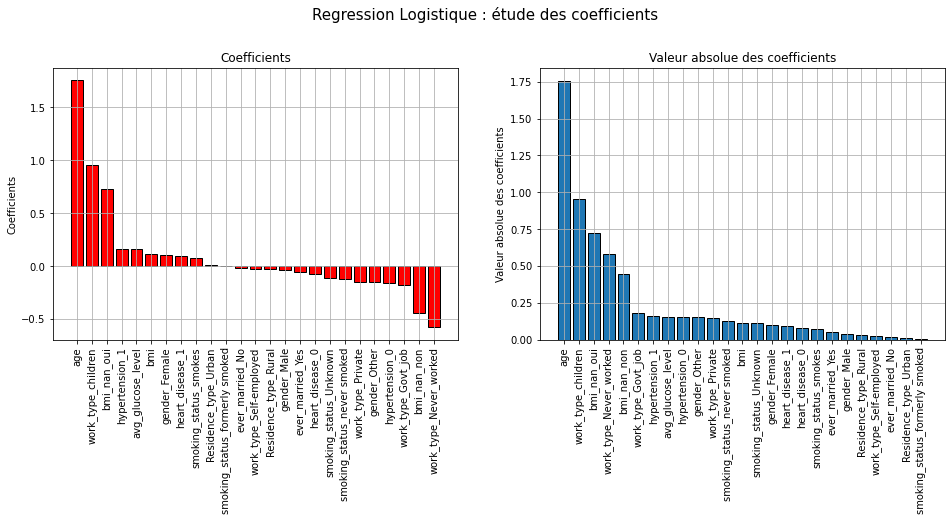

In [50]:
fig, axs=plt.subplots(1,2,figsize=[16,5])
fig.suptitle('Regression Logistique : étude des coefficients', fontsize=15, y=1.05);
for i in range(2):
    axs[i].grid()
    axs[i].tick_params(axis='x',labelrotation=90)
    axs[i].set_xticks(range(len(df_features)))
axs[0].bar(range(len(df_features)),df_features, edgecolor='k', color='r')
axs[0].set_ylabel('Coefficients')
axs[0].set_xticklabels(df_features.index)
axs[0].set_title('Coefficients')

axs[1].bar(range(len(df_features)),np.abs(df_features).sort_values(ascending=False),edgecolor='k')
axs[1].set_ylabel('Valeur absolue des coefficients')
axs[1].set_xticklabels(np.abs(df_features).sort_values(ascending=False).index)
axs[1].set_title('Valeur absolue des coefficients');

### Test avec suppression de features

Dans cette partie, on propose de travailler sur la modification des variables explicatives, fournies au modèle. 

In [51]:
# Différents subset
subset0=X.columns
subset1=np.isin(X.columns, 'ever_married', invert=True)
subset2=np.isin(X.columns, ['work_type','ever_married'], invert=True)
subset3=np.isin(X.columns, ['work_type','ever_married','bmi'], invert=True)
subset4=np.isin(X.columns, ['work_type','ever_married','Residence_type'], invert=True)
subset5=np.isin(X.columns, ['work_type','gender'], invert=True)

In [52]:
subset_values = [subset0, subset1, subset2, subset3, subset4, subset5]
data = {'Subset': [], 'F1': [], 'F1 Beta':[]}

for index in range(0, len(subset_values)):
  subset = subset_values[index]
  X_data = X.loc[:, subset]
  df_result, pipeline, y_pred, cross_val = run_and_evaluate(lr_cv, params, X_data, y)
  f1 = cross_val['test_f1']
  f1beta = cross_val['test_fbeta']
  
  data['Subset'].extend([f'Subset{index}']*KFOLD)
  data['F1'].extend(f1)
  data['F1 Beta'].extend(f1beta)

df_subset = pd.DataFrame(data)
df_subset.head()

,Subset,F1,F1 Beta
0,Subset0,0.226804,0.374150
1,Subset0,0.236620,0.415842
2,Subset0,0.238095,0.411523
3,Subset0,0.231214,0.403226
4,Subset0,0.232416,0.400844


In [53]:
df_subset_grouped = df_subset.groupby('Subset').mean()
df_subset_grouped

,F1,F1 Beta
Subset,,
Subset0,0.233030,0.401117
Subset1,0.231743,0.400774
Subset2,0.236290,0.408239
Subset3,0.234633,0.404974
Subset4,0.235200,0.406912
Subset5,0.231144,0.399615


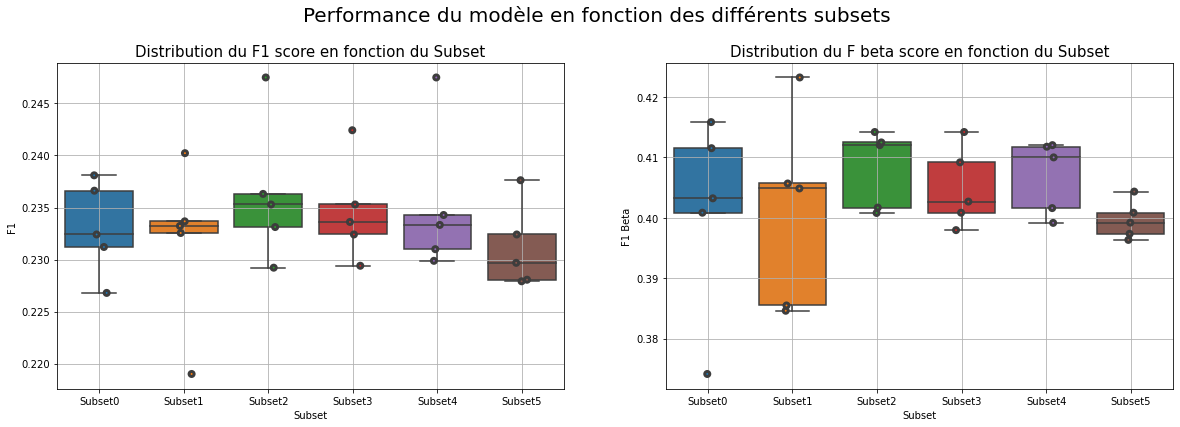

In [54]:
fig, axs= plt.subplots(1,2,figsize=[20,6])

fig.suptitle('Performance du modèle en fonction des différents subsets', fontsize=20,y=1.01)

sns.boxplot(data=df_subset, x='Subset', y='F1', ax=axs[0], fliersize=0)
sns.stripplot(data=df_subset, x='Subset', y='F1', ax=axs[0], linewidth=3)
axs[0].grid(True)
axs[0].set_title('Distribution du F1 score en fonction du Subset',fontsize=15);


sns.boxplot(data=df_subset, x='Subset', y='F1 Beta', ax=axs[1], fliersize=0)
sns.stripplot(data=df_subset, x='Subset', y='F1 Beta', ax=axs[1], linewidth=3)
axs[1].grid(True)
axs[1].set_title('Distribution du F beta score en fonction du Subset', fontsize=15);


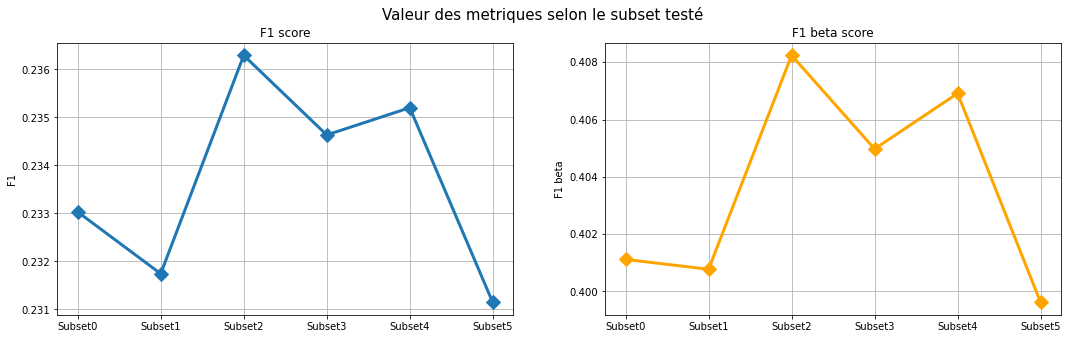

In [55]:
fig, axs = plt.subplots(1,2, figsize=[18,5])

plt.suptitle('Valeur des metriques selon le subset testé', fontsize=15)

axs[0].plot(df_subset_grouped['F1'], marker='D',label='F1', linewidth=3, markersize=10)
axs[0].set_ylabel('F1')
axs[0].set_title('F1 score')

axs[1].plot(df_subset_grouped['F1 Beta'], color='orange', marker='D', label='F1 Beta',linewidth=3, markersize=10)
axs[1].set_ylabel('F1 beta')
axs[1].set_title('F1 beta score')

for i in range(2):
    axs[i].grid()

### Conclusion
- On observe un très bon score F1 ainsi que F1 Beta sur le subset 2. Qui consistait à la suppression des deux features suivantes: `'work_type','ever_married'`. 


In [56]:
X=X.iloc[:,subset2]

In [57]:
variables_numeriques=X.select_dtypes('number').columns
variables_categorielles=X.select_dtypes(exclude = 'number').columns

transformer=make_column_transformer((StandardScaler(), variables_numeriques) \
      ,(OneHotEncoder(handle_unknown='ignore'), variables_categorielles))\

kf=StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=0)
f1b=make_scorer(fbeta_score, beta=2)

# Comparaison de l'efficacité des modèles LogisticRegressionCV, RandomForestClassifier et SVC

## LogisticRegressionCV

In [58]:
df_metrics = pd.DataFrame()
prediction_dictionary = {}

log_reg = LogisticRegressionCV(class_weight='balanced', random_state=0)
params = {'methode': 'Class Weight', 'model': 'Logistic Regression'}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(log_reg, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['Class Weight'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,Class Weight,Logistic Regression,0.779843,0.247492,0.412027,0.148594,0.74000
1,2,Class Weight,Logistic Regression,0.732877,0.235294,0.414201,0.136808,0.84000
2,3,Class Weight,Logistic Regression,0.740705,0.236311,0.412475,0.138047,0.82000
3,4,Class Weight,Logistic Regression,0.736791,0.229226,0.400802,0.133779,0.80000
4,5,Class Weight,Logistic Regression,0.755382,0.233129,0.401691,0.137184,0.77551


In [59]:
df_resu=pd.DataFrame()
for i in range (5):
    df_resu=df_resu.append(pd.DataFrame(cross_val['estimator'][i][1].scores_[1]))
df_resu.columns=np.round(cross_val['estimator'][0][1].Cs_,4)

In [60]:
df_resu_me=df_resu.melt()
df_resu_me=df_resu_me.rename({'variable':'C','value' : 'F beta score'}, axis=1)
df_resu_gb=df_resu_me.groupby('C').agg({'F beta score':[np.mean,np.std,np.median]})
df_resu_gb.sort_values(('F beta score','mean'),ascending=False)

F beta score                    
                   mean       std    median
C                                          
21.5443        0.411364  0.026935  0.418848
166.8101       0.411364  0.026935  0.418848
1291.5497      0.411364  0.026935  0.418848
10000.0000     0.411364  0.026935  0.418848
2.7826         0.411318  0.026830  0.418848
0.3594         0.410202  0.026880  0.418848
0.0464         0.409607  0.028141  0.421196
0.0060         0.405395  0.024425  0.410628
0.0008         0.404207  0.023416  0.406699
0.0001         0.398448  0.024966  0.401460

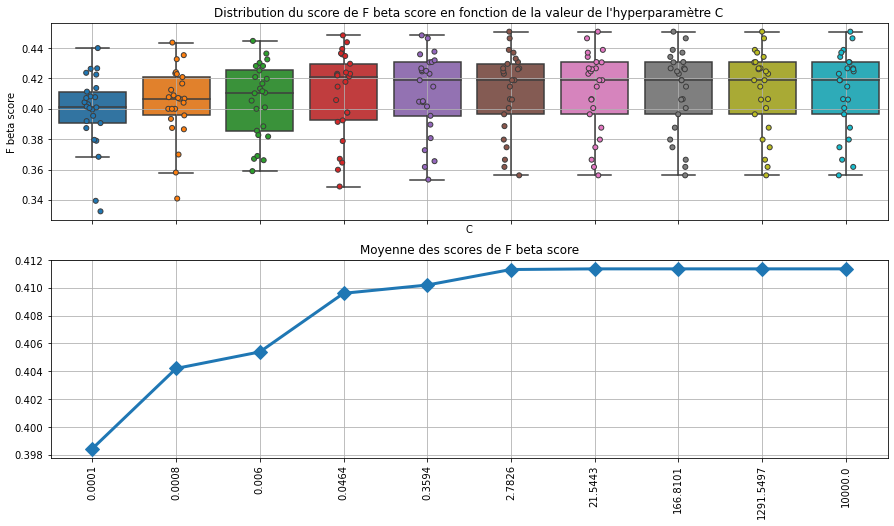

In [61]:
# Box plot de la métrique F1 Beta Score pour chaque hyper parametre C et les 5 KFolds
fig, axs = plt.subplots(2,1,figsize=[15,8], sharex=True)
sns.boxplot(data=df_resu_me, x='C', y='F beta score', ax=axs[0], fliersize=0)
sns.stripplot(data=df_resu_me, x='C', y='F beta score', ax=axs[0],linewidth=1)
axs[0].grid()
axs[0].set_title('Distribution du score de F beta score en fonction de la valeur de l\'hyperparamètre C');

#Plot des moyenne sur KFold pour chaque hyper parametre C
axs[1].plot(df_resu_gb.loc[:,('F beta score','mean')].values, marker='D', linewidth=3, markersize=10)
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].grid()
axs[1].set_title('Moyenne des scores de F beta score');

In [62]:
df_resu_gb.sort_values(('F beta score','mean'), ascending=False)

F beta score                    
                   mean       std    median
C                                          
21.5443        0.411364  0.026935  0.418848
166.8101       0.411364  0.026935  0.418848
1291.5497      0.411364  0.026935  0.418848
10000.0000     0.411364  0.026935  0.418848
2.7826         0.411318  0.026830  0.418848
0.3594         0.410202  0.026880  0.418848
0.0464         0.409607  0.028141  0.421196
0.0060         0.405395  0.024425  0.410628
0.0008         0.404207  0.023416  0.406699
0.0001         0.398448  0.024966  0.401460

In [77]:
pickle_cv_lr=open('cv_lr.pickle','wb')
pickle.dump(cross_val,pickle_cv_lr)

## SVC

In [78]:
df_metrics = pd.DataFrame()
prediction_dictionary = {}

sc=SVC(class_weight='balanced', random_state=0)
pgrid1={'C':[0.1,1,10,100],'gamma':[0.001,0.01,0.1]}
gs1=GridSearchCV(sc, param_grid=pgrid1)

params = {'methode': 'Class Weight', 'model': 'SVC'}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(gs1, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['Class Weight'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,Class Weight,SVC,0.771037,0.240260,0.403930,0.143411,0.74000
1,2,Class Weight,SVC,0.727984,0.227778,0.401961,0.132258,0.82000
2,3,Class Weight,SVC,0.738748,0.207715,0.359343,0.121951,0.70000
3,4,Class Weight,SVC,0.709393,0.216359,0.387524,0.124620,0.82000
4,5,Class Weight,SVC,0.746575,0.226866,0.394191,0.132867,0.77551


In [79]:
df_svc=pd.DataFrame()
for i in range(5):
    df_svc=df_svc.append(pd.DataFrame(cross_val['estimator'][i][1].cv_results_))

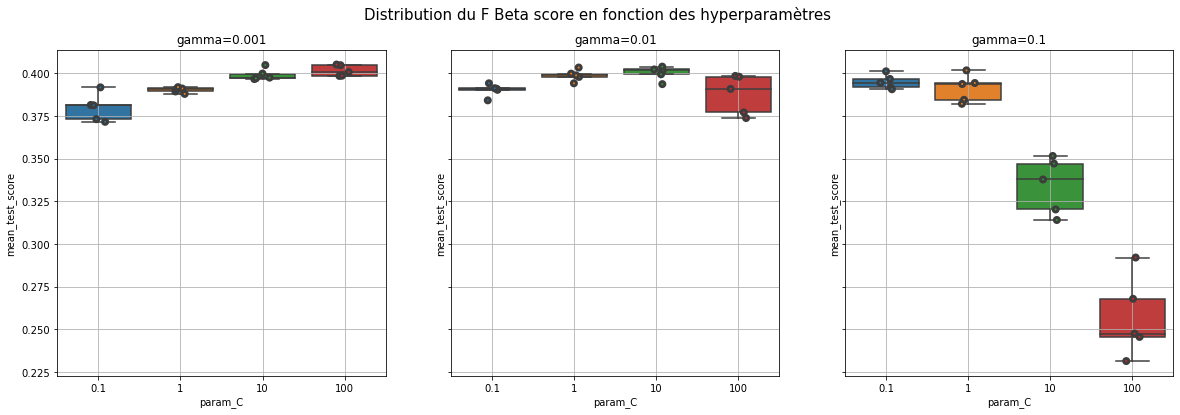

In [80]:
fig,axs=plt.subplots(1,3, figsize=[20, 6], sharey=True)

for n,i in enumerate(df_svc['param_gamma'].unique()):
    sns.boxplot(data=df_svc[df_svc['param_gamma']==i], x='param_C', y='mean_test_score', ax=axs[n],fliersize=0)
    sns.stripplot(data=df_svc[df_svc['param_gamma']==i], x='param_C', y='mean_test_score', ax=axs[n], linewidth=3)

    axs[n].set_title('gamma={}'.format(i))
    axs[n].grid()
fig.suptitle('Distribution du F Beta score en fonction des hyperparamètres', fontsize=15);

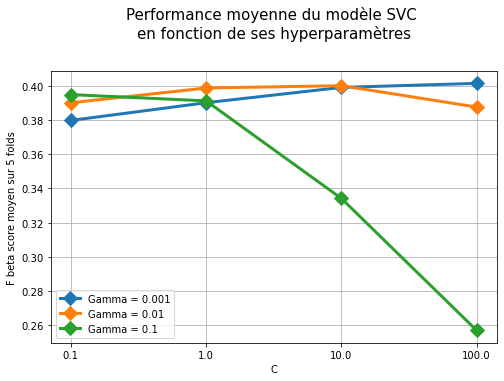

In [81]:
plt.figure(figsize=(8,5))
for gam in [0.001,0.01,0.1]:
    df_temp= df_svc[df_svc['param_gamma']==gam].groupby('param_C').\
        agg({'mean_test_score':'mean'})
    plt.plot(df_temp.values, label='Gamma = {}'.format(gam), marker='D',linewidth=3, markersize=10)

plt.xticks([0,1,2,3], labels=df_temp.index)
plt.xlabel('C')
plt.ylabel('F beta score moyen sur 5 folds')
plt.legend()
plt.grid()
plt.title('Performance moyenne du modèle SVC \nen fonction de ses hyperparamètres',y=1.1, fontsize=15);

In [82]:
df_scv_gb=df_svc.groupby(['param_C','param_gamma']).agg({'mean_test_score':[np.mean,np.std, np.median]}).\
sort_values(('mean_test_score','mean'),ascending=False)
df_scv_gb

mean_test_score                    
                               mean       std    median
param_C param_gamma                                    
100.0   0.001              0.401529  0.003241  0.400729
10.0    0.010              0.400176  0.003987  0.401663
        0.001              0.399157  0.003403  0.397459
1.0     0.010              0.398803  0.003332  0.398810
0.1     0.100              0.394940  0.004204  0.394465
1.0     0.100              0.391267  0.007991  0.393735
        0.001              0.390186  0.001565  0.390674
0.1     0.010              0.390153  0.003666  0.390917
100.0   0.010              0.387631  0.011599  0.390839
0.1     0.001              0.379816  0.008073  0.381243
10.0    0.100              0.334117  0.016463  0.337759
100.0   0.100              0.256804  0.023588  0.247447

In [83]:
pickle_cv_svc=open('cv_svc.pickle','wb')
pickle.dump(cross_val,pickle_cv_svc)

## RandomForestClassifier

In [84]:
df_metrics = pd.DataFrame()
prediction_dictionary = {}
rf=RandomForestClassifier(class_weight='balanced',random_state=0)
pgrid2={'max_depth':[3,4,5,6], 'n_estimators':[100, 1000]}
gs2=GridSearchCV(rf, param_grid=pgrid2)

params = {'methode': 'Class Weight', 'model': 'Random Forrest'}
df_result, pipeline, y_pred, cross_val  = run_and_evaluate(gs2, params, X, y)
df_metrics=df_metrics.append(df_result)
prediction_dictionary['Class Weight'] = y_pred
df_metrics.tail(5)

,KFold,methode,model,test_accuracy,test_f1,test_fbeta,test_precision,test_recall
0,1,Class Weight,Random Forrest,0.821918,0.254098,0.393401,0.159794,0.620000
1,2,Class Weight,Random Forrest,0.767123,0.242038,0.409483,0.143939,0.760000
2,3,Class Weight,Random Forrest,0.708415,0.207447,0.370722,0.119632,0.780000
3,4,Class Weight,Random Forrest,0.737769,0.225434,0.393145,0.131757,0.780000
4,5,Class Weight,Random Forrest,0.770059,0.239482,0.405702,0.142308,0.755102


In [85]:
df_rf=pd.DataFrame()
for i in range(5):
    df_rf=df_rf.append(pd.DataFrame(cross_val['estimator'][i][1].cv_results_))

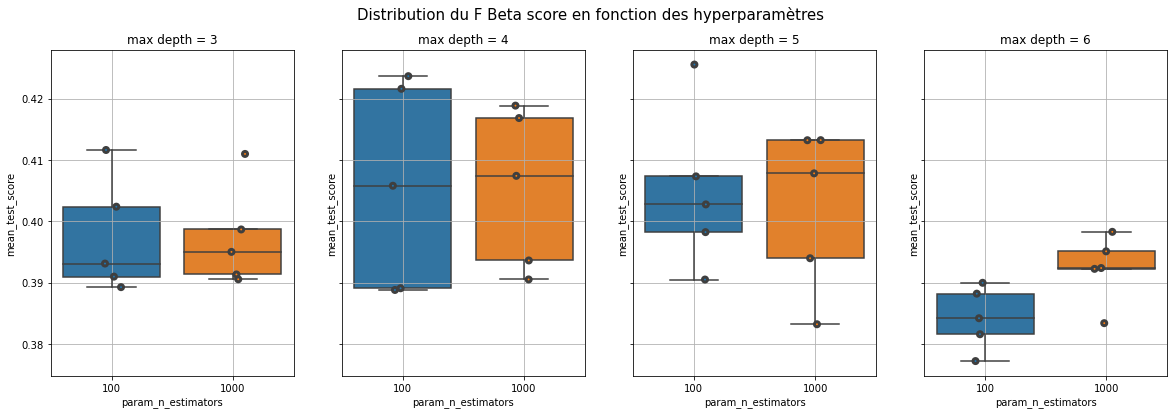

In [86]:
fig,axs=plt.subplots(1,4, figsize=[20,6], sharey=True)

for n,i in enumerate(df_rf['param_max_depth'].unique()):
    sns.boxplot(data=df_rf[df_rf['param_max_depth']==i], x='param_n_estimators',\
                y='mean_test_score', ax=axs[n],fliersize=0)
    sns.stripplot(data=df_rf[df_rf['param_max_depth']==i], x='param_n_estimators',\
                  y='mean_test_score', ax=axs[n], linewidth=3)

    axs[n].set_title('max depth = {}'.format(i))
    axs[n].grid()
fig.suptitle('Distribution du F Beta score en fonction des hyperparamètres', fontsize=15);

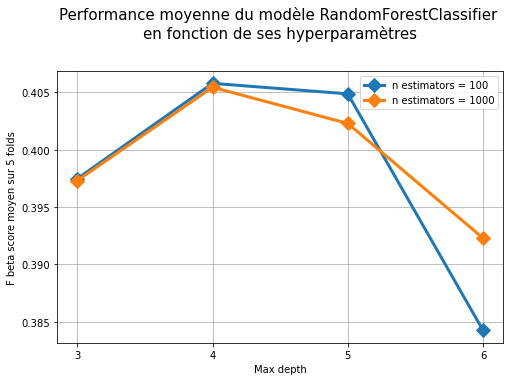

In [87]:
plt.figure(figsize=(8,5))
for est in [100,1000]:
    df_temp= df_rf[df_rf['param_n_estimators']==est].groupby('param_max_depth').\
        agg({'mean_test_score':'mean'})
    plt.plot(df_temp.values, label='n estimators = {}'.format(est), marker='D',linewidth=3, markersize=10)

plt.xticks([0,1,2,3], labels=df_temp.index)
plt.xlabel('Max depth')
plt.ylabel('F beta score moyen sur 5 folds')
plt.legend()
plt.grid()
plt.title('Performance moyenne du modèle RandomForestClassifier \nen fonction de ses hyperparamètres',y=1.1, fontsize=15);

In [88]:
df_rf_gb=df_rf.groupby(['param_n_estimators','param_max_depth']).agg({'mean_test_score':[np.mean,np.std,np.median]}).\
sort_values(('mean_test_score','mean'),ascending=False)
df_rf_gb

mean_test_score                    
                                              mean       std    median
param_n_estimators param_max_depth                                    
100                4                      0.405783  0.016860  0.405789
1000               4                      0.405442  0.013002  0.407407
100                5                      0.404867  0.013122  0.402747
1000               5                      0.402285  0.013253  0.407810
100                3                      0.397467  0.009394  0.393106
1000               3                      0.397304  0.008299  0.395007
                   6                      0.392275  0.005544  0.392375
100                6                      0.384228  0.005123  0.384190

In [89]:
pickle_cv_rf=open('cv_rf.pickle','wb')
pickle.dump(cross_val,pickle_cv_rf)

## Comparatif des modèles

Partie où on compare les nos trois modèles

In [90]:
mean_lr=df_resu_gb.loc[10000,('F beta score','mean')]
std_lr=df_resu_gb.loc[10000,('F beta score','std')]

mean_rf=df_rf_gb.loc[(100,4),('mean_test_score','mean')]
std_rf=df_rf_gb.loc[(100,4),('mean_test_score','std')]

mean_svc=df_scv_gb.loc[(100,0.001),('mean_test_score','mean')]
std_svc=df_scv_gb.loc[(100,0.001),('mean_test_score','std')]

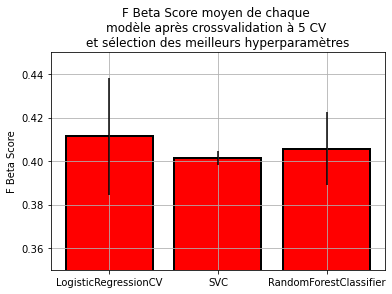

In [91]:
plt.grid()
plt.bar([0,1,2],[mean_lr,mean_svc,mean_rf], yerr=[std_lr,std_svc,std_rf],
        edgecolor='k', linewidth=2, color='r')
plt.ylim((0.35,0.45))
plt.xticks([0,1,2],['LogisticRegressionCV','SVC','RandomForestClassifier'])
plt.ylabel('F Beta Score');
plt.title('F Beta Score moyen de chaque \nmodèle après crossvalidation à 5 CV \net sélection des meilleurs hyperparamètres');

Le modèle qui utilise la LogisticRegressionCV affiche le F beta score le plus élevé mais est légèrement moins stable que les deux autres

---

## Fit des modèles / Sauvegarde
Partie où on fit les modèles (LR, SVC et RF) avec leur meilleurs hyper parametres + sauvegarde pour la suite 

In [92]:
variables_numeriques=X.select_dtypes('number').columns
variables_categorielles=X.select_dtypes(exclude = 'number').columns

transformer=make_column_transformer((StandardScaler(), variables_numeriques) \
    ,(OneHotEncoder(handle_unknown='ignore'), variables_categorielles))


In [94]:
# Création des modèles
lr_final=LogisticRegressionCV(class_weight='balanced', random_state=0)
rf_final=RandomForestClassifier(max_depth=4, n_estimators=100,class_weight='balanced', random_state=0)
svc_final=SVC(gamma=100, C=0.001,class_weight='balanced', random_state=0)

In [95]:
# Logistic Regression
pip_fin_1=make_pipeline(transformer,lr_final)
pip_fin_1.fit(X,y)
pickle_lr=open('lr.pickle','wb')
pickle.dump(pip_fin_1, pickle_lr)

In [96]:
# RandomForest
pip_fin_2=make_pipeline(transformer,rf_final)
pip_fin_2.fit(X,y)
pickle_rf=open('rf.pickle','wb')
pickle.dump(pip_fin_2,pickle_rf)

In [97]:
# SVC
pip_fin_3=make_pipeline(transformer,svc_final)
pip_fin_3.fit(X,y)
pickle_svc=open('svc.pickle','wb')
pickle.dump(pip_fin_3,pickle_svc)